In [4]:
# load all data
import os
import polars as pl
data_dir = "./data/all_inputs_iui_original_music_roll_features"
df = pl.DataFrame()
for name in os.listdir(data_dir):
    load_df = pl.read_parquet(os.path.join(data_dir, name))
    df = df.vstack(load_df)

black_list = set()
with open("black_list.txt") as f:
    for l in f.readlines():
        num = l.removesuffix("\n")
        black_list.add(f"dance_data_{num}_corrected")
print(black_list)

df = df.with_columns(
    pl.col("win_c").alias("win_split"),
).drop(
    pl.col("win_c"),
    pl.col("name_orig")
)
df = df.filter(
    ~pl.col("name").is_in(black_list)
)

print(df.columns)
print(df)


{'dance_data_105_corrected', 'dance_data_146_corrected', 'dance_data_117_corrected', 'dance_data_170_corrected', 'dance_data_120_corrected', 'dance_data_40_corrected', 'dance_data_219_corrected', 'dance_data_17_corrected', 'dance_data_111_corrected', 'dance_data_103_corrected', 'dance_data_155_corrected', 'dance_data_220_corrected', 'dance_data_104_corrected', 'dance_data_114_corrected', 'dance_data_221_corrected', 'dance_data_108_corrected', 'dance_data_110_corrected', 'dance_data_28_corrected', 'dance_data_118_corrected', 'dance_data_116_corrected', 'dance_data_109_corrected', 'dance_data_115_corrected', 'dance_data_106_corrected', 'dance_data_119_corrected', 'dance_data_169_corrected', 'dance_data_113_corrected', 'dance_data_112_corrected', 'dance_data_107_corrected'}
['f1_min', 'f1_max', 'f1_std', 'f1_mean', 'f2_min', 'f2_max', 'f2_std', 'f2_mean', 'f3_min', 'f3_max', 'f3_std', 'f3_mean', 'f4_min', 'f4_max', 'f4_std', 'f4_mean', 'f5_min', 'f5_max', 'f5_std', 'f5_mean', 'f6_min', 'f

> **_NOTE:_** : Run this script to load all the R values for the various Pearson's R analysis.

In [5]:
# Analysis 3 - get r value of input to output
import polars as pl
from scipy.stats import pearsonr
from tqdm import tqdm

input_df = pl.read_csv("all_inputs_iui_features.csv").drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
input_df = input_df.filter(
    ~pl.col("name").is_in(black_list)
)

output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
name_df = df.clone()

# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    # pl.col("num"),
    # pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
print(scaling_df.columns)
concat_df = output_df.select(
    pl.col("name"),
    # pl.col("num"),
    # pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
print(scaling_df.columns)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


wins = df.with_columns(
    win_split_num = pl.col("win_split").cast(pl.Int64)
)["win_split_num"].sort().unique().to_list()

r_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("music") == music,
        ).drop("name", "music")

        for win in range(0, 13):
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            r = pearsonr(inputs[0, :], output[0, :], alternative="two-sided") 
            r_dict = {"name": name, "music": music, "win": win, "r": r.statistic}
            r_df = r_df.vstack(pl.from_dict(r_dict))
    
r_df.write_parquet("r_val_df.parquet")

['f1_max', 'f1_std', 'f1_mean', 'f2_max', 'f2_std', 'f2_mean', 'f3_max', 'f3_std', 'f3_mean', 'f4_max', 'f4_std', 'f4_mean', 'f5_max', 'f5_std', 'f5_mean', 'f6_max', 'f6_std', 'f6_mean', 'f7_max', 'f7_std', 'f7_mean', 'f8_max', 'f8_std', 'f8_mean', 'f30_max', 'f30_std', 'f30_mean', 'f31_max', 'f31_std', 'f31_mean', 'f11_max', 'f11_std', 'f11_mean', 'f13_max', 'f13_std', 'f13_mean', 'f14_max', 'f14_std', 'f14_mean', 'f15_max', 'f15_std', 'f15_mean', 'f17_max', 'f17_std', 'f17_mean', 'f18_max', 'f18_std', 'f18_mean', 'f19_max', 'f19_std', 'f19_mean']
['f1_max', 'f1_std', 'f1_mean', 'f2_max', 'f2_std', 'f2_mean', 'f3_max', 'f3_std', 'f3_mean', 'f4_max', 'f4_std', 'f4_mean', 'f5_max', 'f5_std', 'f5_mean', 'f6_max', 'f6_std', 'f6_mean', 'f7_max', 'f7_std', 'f7_mean', 'f8_max', 'f8_std', 'f8_mean', 'f30_max', 'f30_std', 'f30_mean', 'f31_max', 'f31_std', 'f31_mean', 'f11_max', 'f11_std', 'f11_mean', 'f13_max', 'f13_std', 'f13_mean', 'f14_max', 'f14_std', 'f14_mean', 'f15_max', 'f15_std', 'f15

100%|██████████| 193/193 [05:19<00:00,  1.65s/it]


## Pearson's R Comparison Input and Output
We take the 3.7 second input motion and compare it against each 3.7 second segment from the output motion.
The first comparison is purely on the R value spread per time ordinal.
Time ordinal refers to which 3.7 second segment we are referring to.

win: 0 - 0.29299725342615357
win: 1 - 0.26924835234947403
win: 2 - 0.25092233887505977
win: 3 - 0.2508519659029442
win: 4 - 0.2550349374137558
win: 5 - 0.2698633180977407
win: 6 - 0.27013197457420934
win: 7 - 0.2680540881301524
win: 8 - 0.26950549892685843
win: 9 - 0.26854261485477965
win: 10 - 0.2685775679742069
win: 11 - 0.2717730950890545
win: 12 - 0.2677492408630384


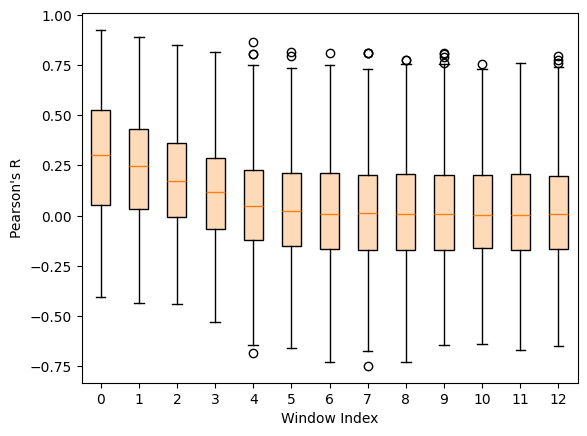

In [6]:
import matplotlib.pylab as plt

ax = plt.subplot()
r_list = []
r_mean_list = []
stds = []
for win in wins:
    rs = r_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["r"].to_numpy()
    r_list.append(rs)
    r_mean_list.append(rs.mean())
    print(f"win: {win} - {rs.std()}")
bp = ax.boxplot(r_list, patch_artist=True)
patches = bp["boxes"]
for patch in patches:
    patch.set_facecolor("peachpuff")
ax.set_xticklabels(wins)
ax.set_xlabel("Window Index")
ax.set_ylabel("Pearson's R")
plt.show()


## Pearson's R Comparison For Different Music Genres

We generated the output on 10 different genres of music as labeled by the AIST dance database dataset.
This comparison is to see the difference that different music genres has on the relevance of the input to the output per time ordinal.

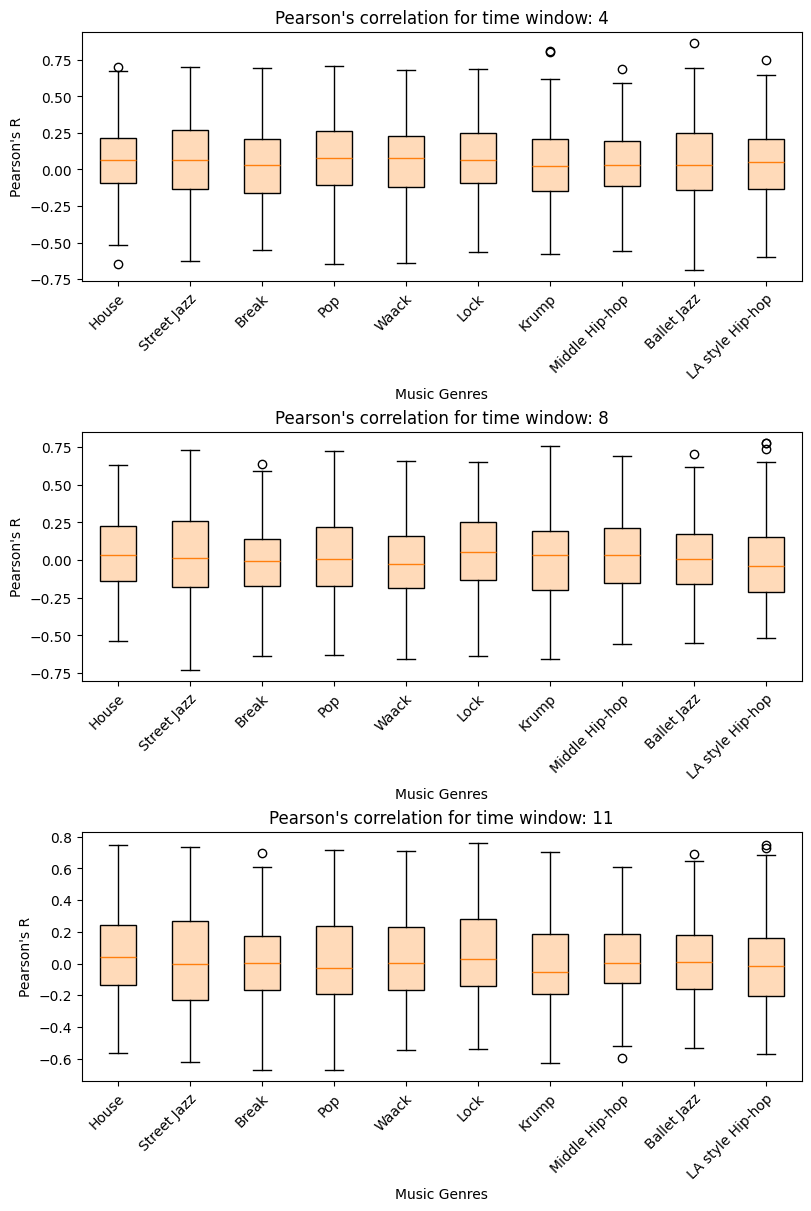

In [7]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
    "NoM":  "No Music",
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), layout="constrained")
for i, win in enumerate([4, 8, 11]):
    r_list = []
    xlab_list = []
    for music in musics:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs)
        xlab_list.append(music_dict[music])
    bp = axes[i].boxplot(r_list, patch_artist=True)
    patches = bp["boxes"]
    for patch in patches:
        patch.set_facecolor("peachpuff")
    axes[i].set_xticklabels(xlab_list, rotation=45, ha="right", rotation_mode="anchor")
    axes[i].set_title(f"Pearson's correlation for time window: {win}")
    axes[i].set_xlabel("Music Genres")
    axes[i].set_ylabel("Pearson's R")
plt.show()

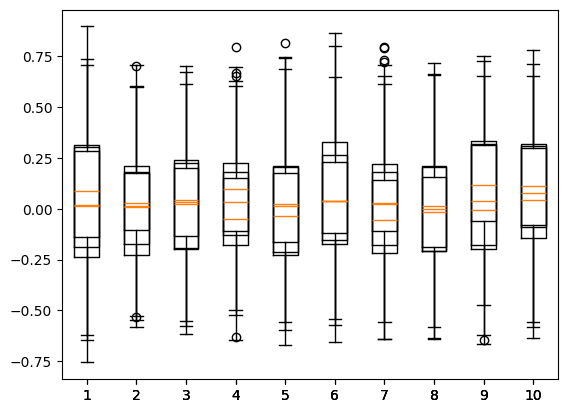

In [6]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
    "NoM":  "No Music",
}

_, ax = plt.subplots()
for i, win in enumerate([4, 8, 12]):
    r_list = []
    for music in musics:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs)
    ax.boxplot(r_list)
plt.show()

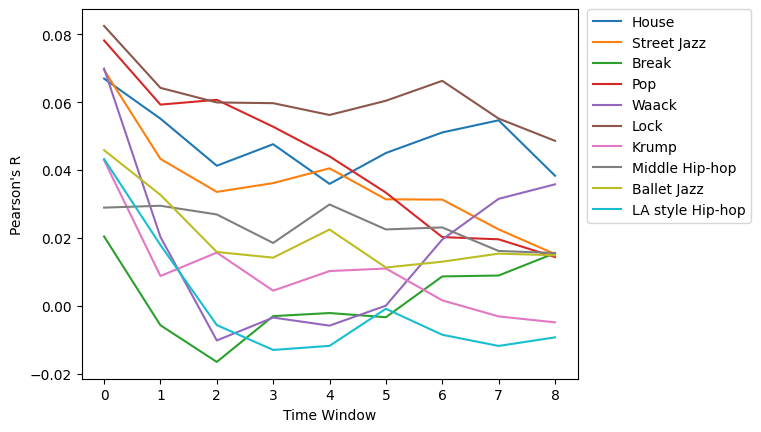

In [8]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
    "NoM":  "No Music",
}

ax = plt.subplot()
for music in musics:
    r_list = []
    for win in wins[4:]:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs.mean())
    ax.plot(r_list, label=music_dict[music])
plt.xlabel("Time Window")
plt.ylabel("Pearson's R")
# plt.ylim([-0.06, 0.13])
ax.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)
plt.show()

## Pearson's R Comparison for Different Clusters

This comparison compares how input motion from different clusters has different relevance for their output

shape: (204, 2)
┌──────────────────────────┬─────────┐
│ name                     ┆ cluster │
│ ---                      ┆ ---     │
│ str                      ┆ i64     │
╞══════════════════════════╪═════════╡
│ dance_data_27_corrected  ┆ 0       │
│ dance_data_22_corrected  ┆ 0       │
│ dance_data_4_corrected   ┆ 0       │
│ dance_data_75_corrected  ┆ 0       │
│ dance_data_25_corrected  ┆ 0       │
│ …                        ┆ …       │
│ dance_data_147_corrected ┆ 7       │
│ dance_data_212_corrected ┆ 7       │
│ dance_data_48_corrected  ┆ 7       │
│ dance_data_164_corrected ┆ 7       │
│ dance_data_163_corrected ┆ 7       │
└──────────────────────────┴─────────┘
203


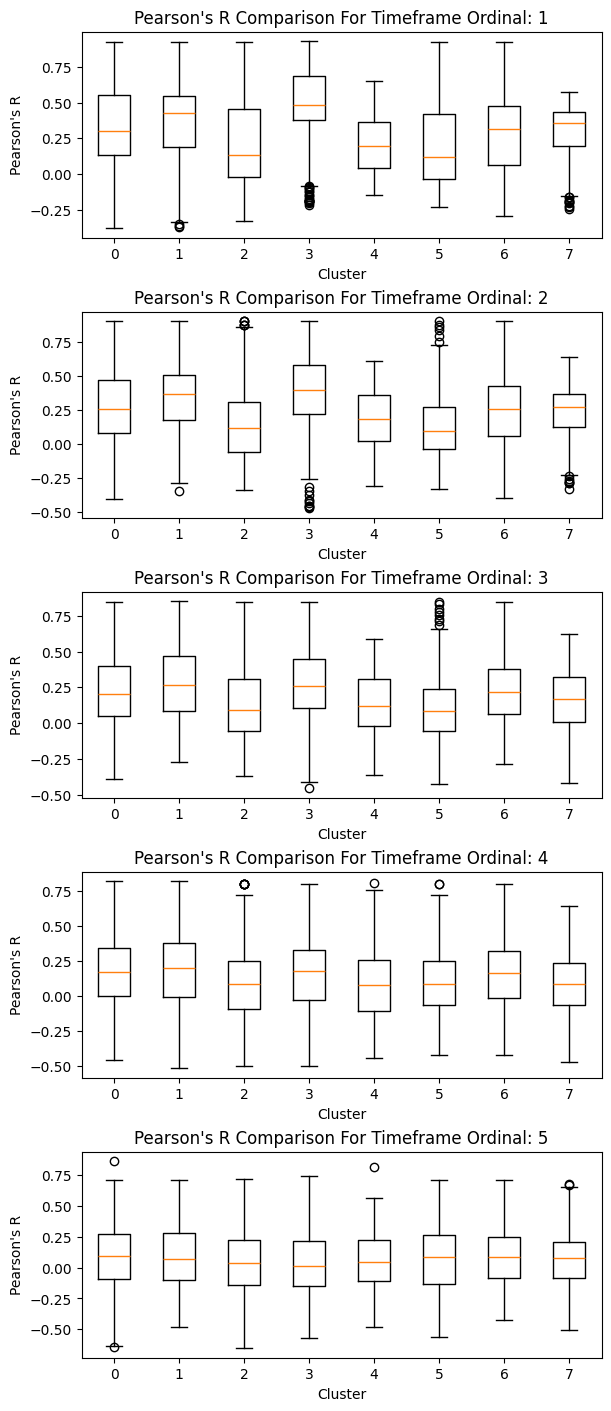

In [8]:

import matplotlib.pylab as plt

fig, axs = plt.subplots(5, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("dance_clustering_fixed.csv")
print(cluster_df)
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()
debug_name = joined_df["name"].unique().to_list()
print(len(debug_name))

for win in range(0, 5):
    r_list = []
    for cluster in clusters:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        r_list.append(rs)
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()

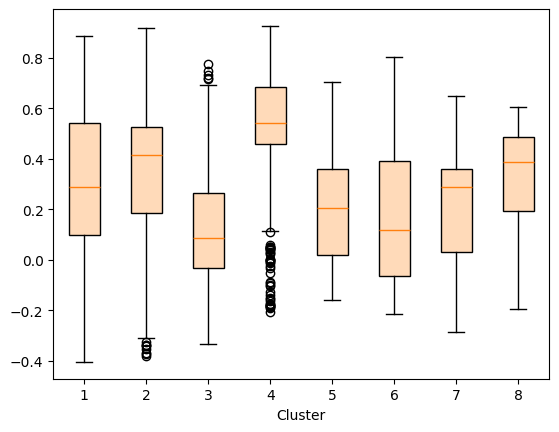

In [9]:

import matplotlib.pylab as plt

ax = plt.subplot()
cluster_df = pl.read_csv("dance_clustering_fixed.csv")
filtered_df = r_df.filter(
    pl.col("music") != "NoM"
)
joined_df = filtered_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

r_list = []
for cluster in clusters:
    rs = joined_df.filter(
        pl.col("win") == 0,
        pl.col("cluster") == cluster,
    )["r"].to_numpy()
    r_list.append(rs)
    
bp = ax.boxplot(r_list, patch_artist=True)
patches = bp["boxes"]
for patch in patches:
    patch.set_facecolor("peachpuff")
ax.set_xticklabels([l + 1 for l in clusters])
plt.xlabel("Cluster")
plt.show()

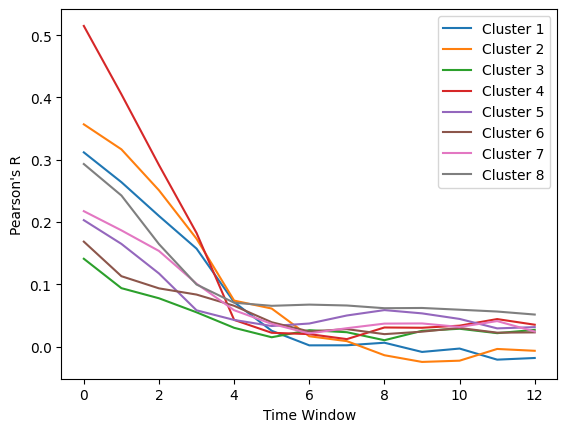

In [24]:

import matplotlib.pylab as plt

ax = plt.subplot()
cluster_df = pl.read_csv("dance_clustering_fixed.csv")
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for cluster in clusters:
    r_list = []
    for win in wins:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        r_list.append(rs.mean())
        
    ax.plot(r_list, label=f"Cluster {cluster + 1}")
plt.xlabel("Time Window")
plt.ylabel("Pearson's R")
plt.legend()
plt.show()

## Person's R Comparison For Different Music and Different Clusters
The purpose of this comparison is to see what cluster paired with what music generates highly relevant output, which what cluster and what music combination results in less relevant outputs.

**Still need to figure out a better way to display this information**

/home/jzho987/anaconda3/envs/ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


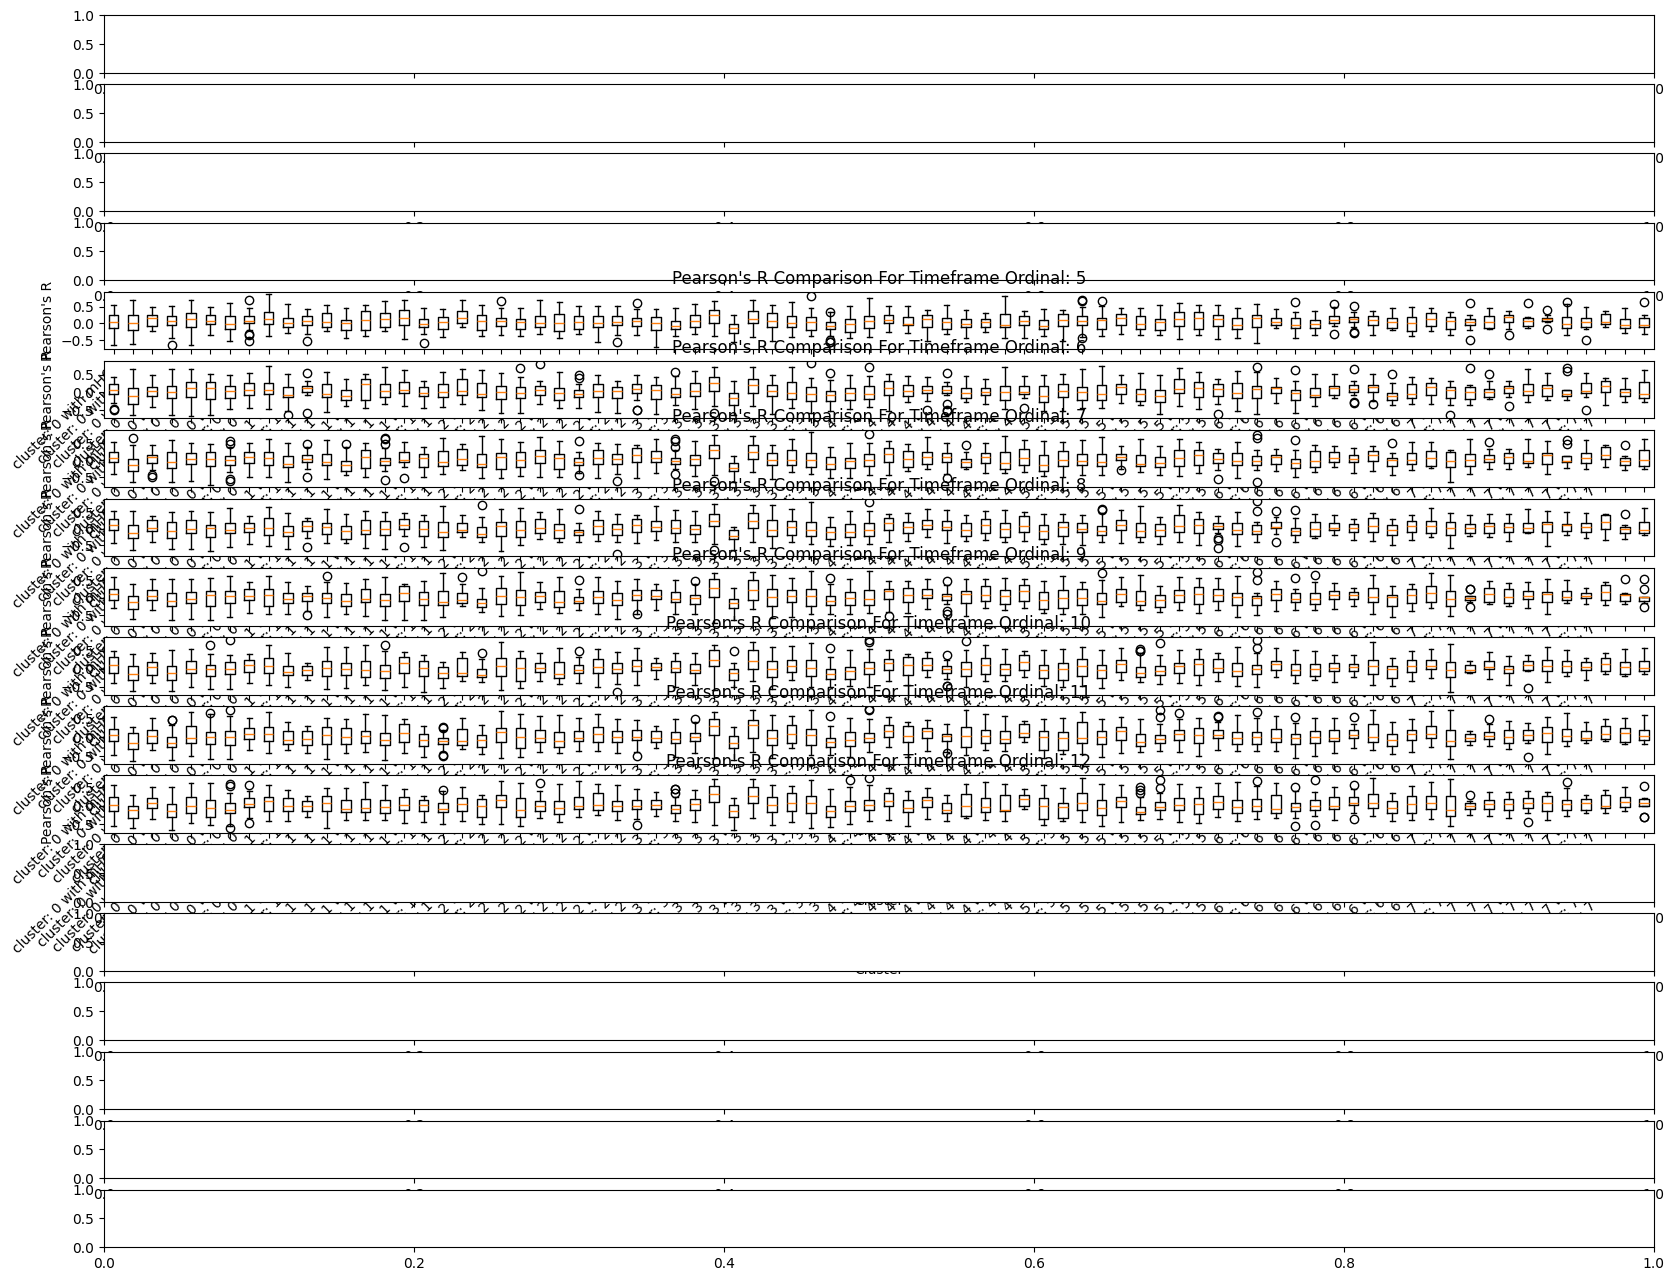

In [18]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(18, 1, figsize=(20, 16), layout="constrained")
cluster_df = pl.read_csv("dance_clustering_fixed.csv")
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(4, 12):
    r_list = []
    label_list = []
    for cluster in clusters:
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            label_list.append(f"cluster: {cluster} with {music}")
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(label_list, rotation=45, ha="right", rotation_mode="anchor")
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()


## Per Genre Of Music, Find Which Cluster Grants Highest Mean R


[0.42849536392035015, 0.3901500409914746, 0.3709698555557762, 0.28614945955707105, 0.2095477290813835, 0.16661045168614855, 0.1891607900163902, 0.18031522681191475, 0.1694800592252353, 0.2216557183887335, 0.22589826166959576, 0.20513182166324578, 0.1752732089645193] cluster: 7 with
Street Jazz
[0.4020371106236647, 0.2639994445987312, 0.27157462070851357, 0.18832911414148779, 0.13367577980674672, 0.12551225341486114, 0.07382638503376417, 0.080344783694022, 0.06004507315982724, 0.05956751893485139, 0.03529313109850079, 0.024577769647986445, 0.029059002486387268] cluster: 6 with
Middle Hip-hop
[0.4154737223444886, 0.3011209315035272, 0.2557450138648172, 0.19656142834637597, 0.1027128137585854, 0.07128263774792108, 0.04302599479970438, 0.02515567823567291, 0.04760026028628556, 0.08064764693073377, 0.054364970290404144, 0.07655799270440106, 0.04751818530842103] cluster: 6 with
House
[0.39956393542726854, 0.31954743295542487, 0.275311415779925, 0.19604756632550913, 0.1557053823340459, 0.0646

Text(0.5, 1.0, "Pearson's R Comparison Most Impacted Cluster Per Music")

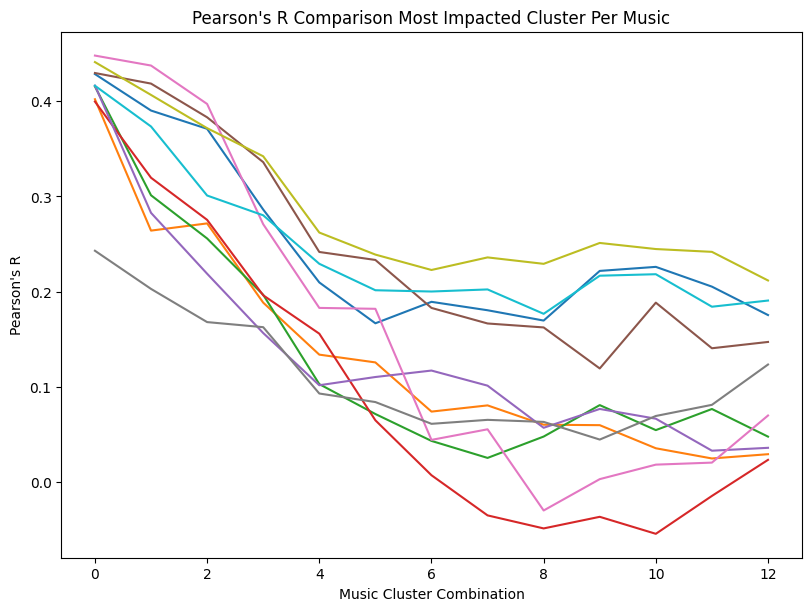

In [41]:

# Do this for ordinal 1 first
win_filter = 4
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win_filter,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        order_dict = {
            "mean": rs.mean(),
            "music": music,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

        for win in wins:
            r = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            mean_r = np.mean(r)
            if label not in r_dict:
                r_dict[label] = [mean_r]
            else:
                r_dict[label].append(mean_r)
            

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout="constrained")
rs = []
labels = []
for music in musics:
    cur_df = order_df.filter(
        pl.col("music") == music
    )
    cur_df = cur_df.sort(by=pl.col("mean"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

for r, label in zip(rs, labels):
    print(r, label)
    ax.plot(r, label=label)
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison Most Impacted Cluster Per Music")


## Per Cluster, Find Which Genre Of Music Grants Highest Mean R

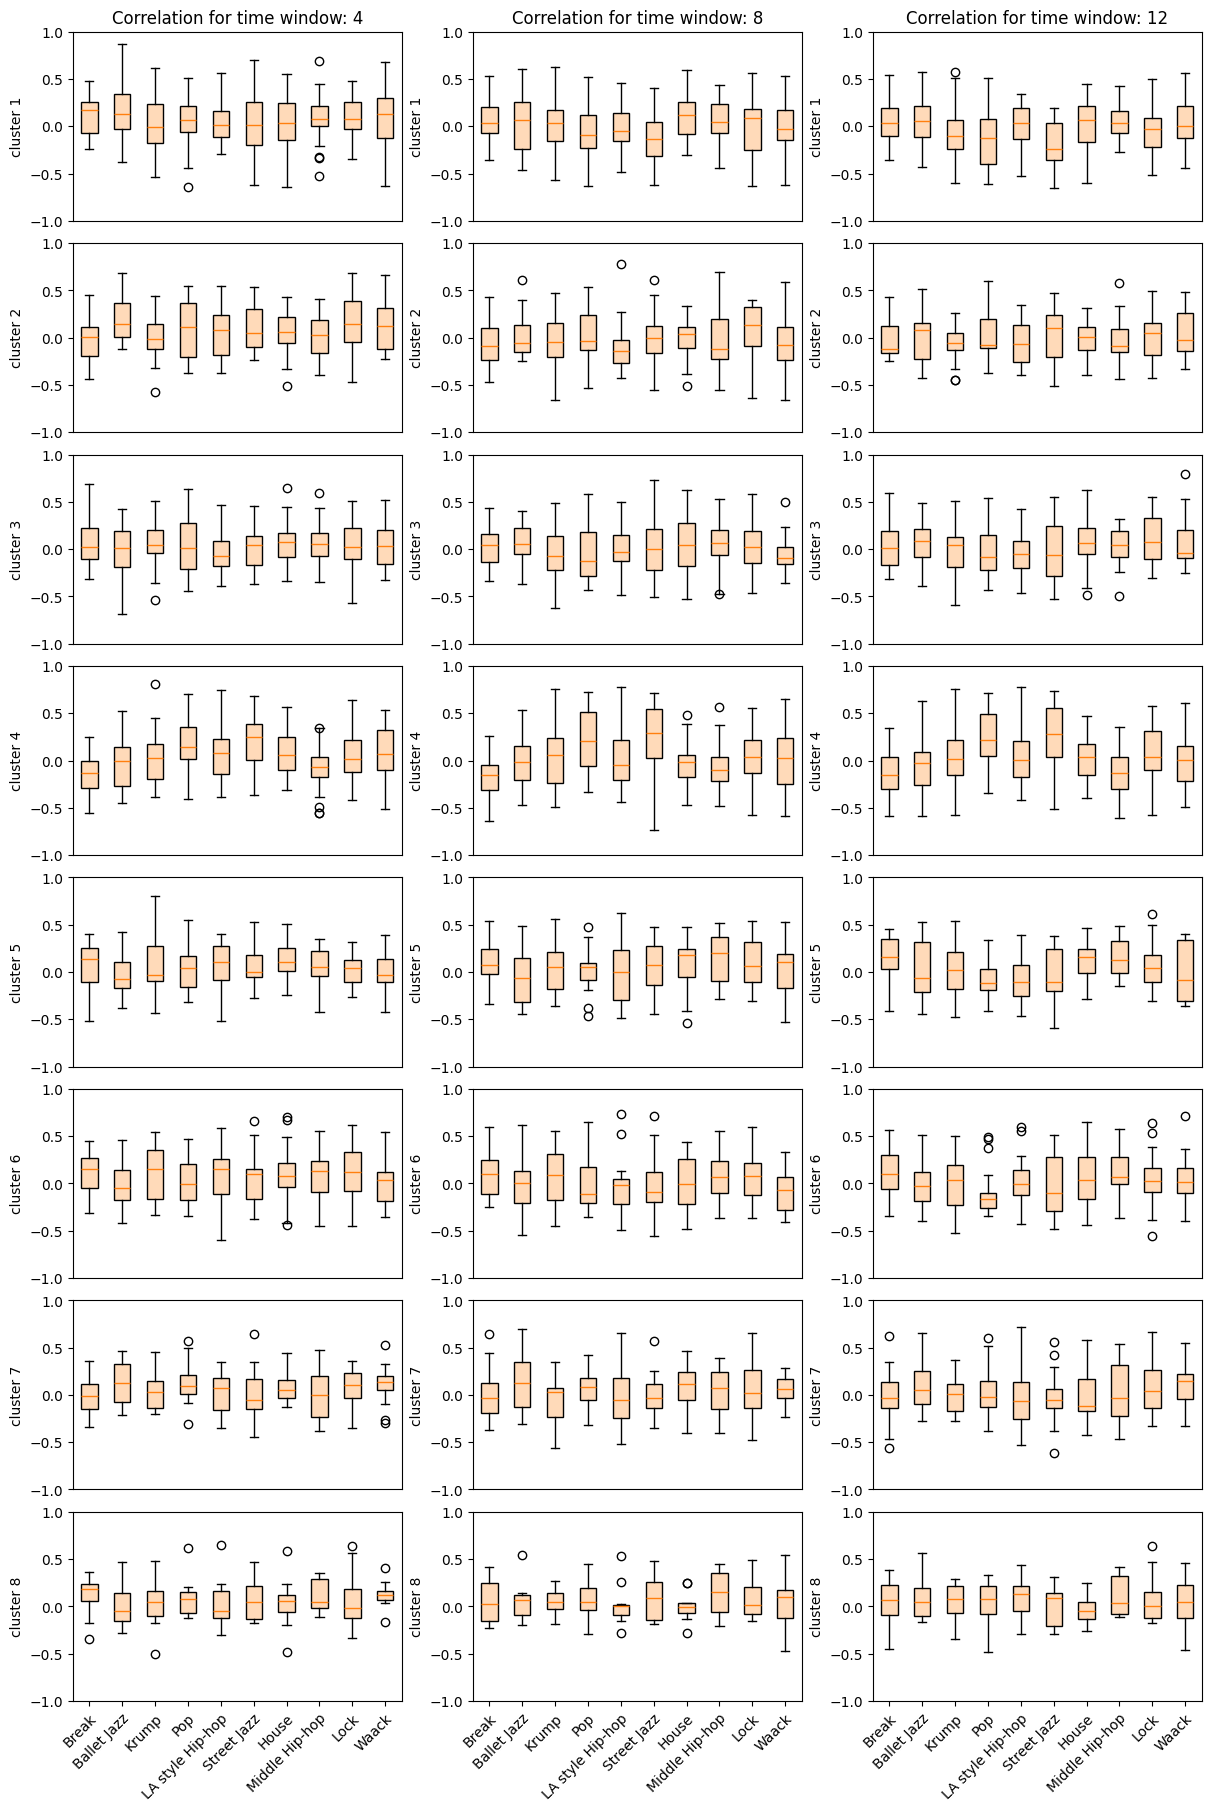

In [27]:


wins_sel = [4, 8, 12]

fig, axes = plt.subplots(len(clusters), len(wins_sel), figsize=(12, 18), layout="constrained")
for j, win in enumerate(wins_sel):
    axes[0, j].set_title(f"Correlation for time window: {win}")
    last_cluster_index = len(clusters) - 1
    for i, cluster in enumerate(clusters):
        r_list = []
        labels = []
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            labels.append(music_dict[music])

        bp = axes[i, j].boxplot(r_list, patch_artist=True)
        axes[i, j].set_ylabel(f"cluster {cluster + 1}")
        patches = bp["boxes"]
        for patch in patches:
            patch.set_facecolor("peachpuff")
        if i != last_cluster_index:
            axes[i, j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='major',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)
        else:
            axes[i, j].set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
        axes[i, j].set_ylim([-1.0, 1.0])
plt.show()

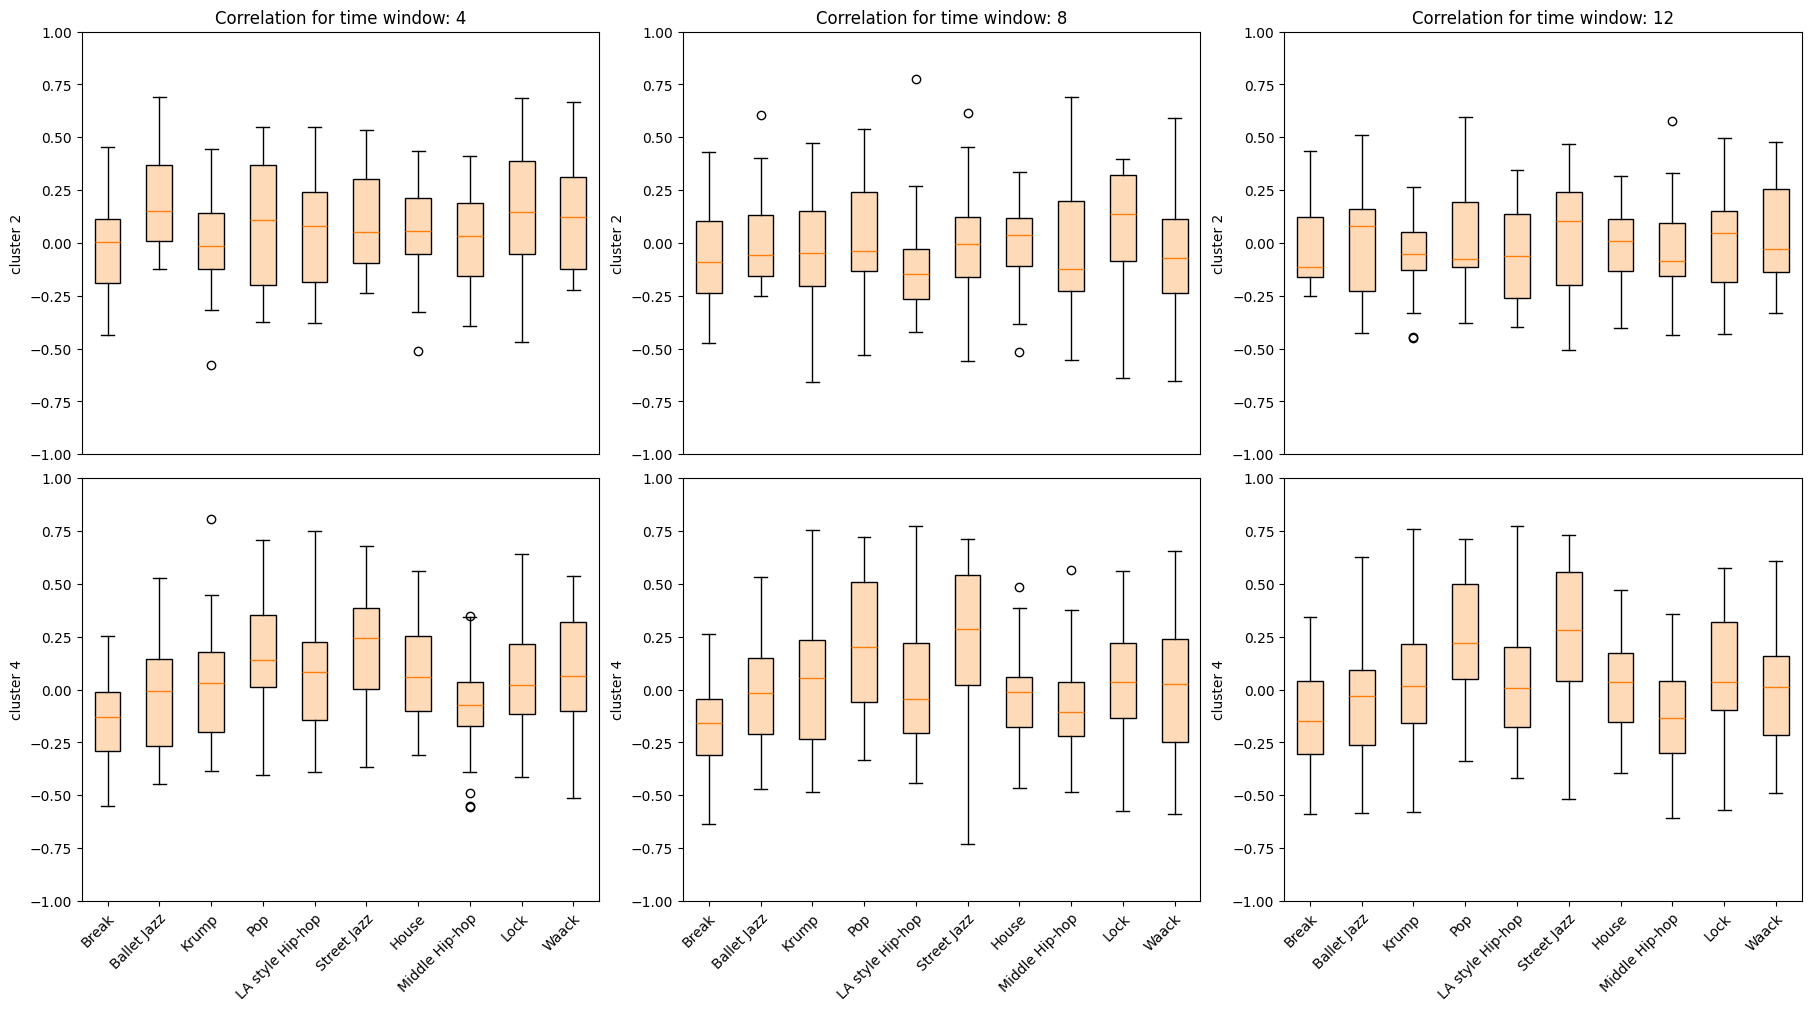

In [30]:

wins_sel = [4, 8, 12]
sum_clusters = [1, 3]

fig, axes = plt.subplots(len(sum_clusters), len(wins_sel), figsize=(len(wins_sel) * 6, len(sum_clusters) * 5), layout="constrained")
for j, win in enumerate(wins_sel):
    axes[0, j].set_title(f"Correlation for time window: {win}")
    last_cluster_index = len(sum_clusters) - 1
    for i, cluster in enumerate(sum_clusters):
        r_list = []
        labels = []
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            labels.append(music_dict[music])

        bp = axes[i, j].boxplot(r_list, patch_artist=True)
        axes[i, j].set_ylabel(f"cluster {cluster + 1}")
        patches = bp["boxes"]
        for patch in patches:
            patch.set_facecolor("peachpuff")
        if i != last_cluster_index:
            axes[i, j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='major',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)
        else:
            axes[i, j].set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
        axes[i, j].set_ylim([-1.0, 1.0])
plt.show()

Text(0.5, 1.0, "Pearson's R Comparison For Best Music For Each Cluster")

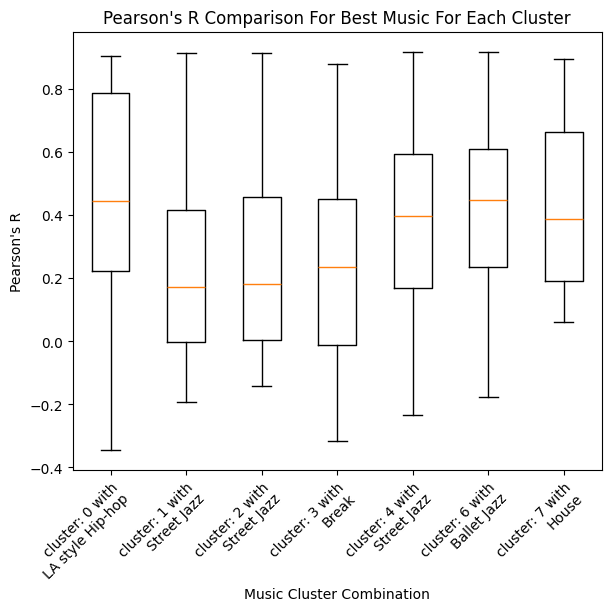

In [19]:
import numpy as np

# Do this for ordinal 1 first
win = 0
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "sort_key": np.quantile(rs, 0.1),
            "cluster": cluster,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
rs = []
labels = []
for cluster in clusters:
    cur_df = order_df.filter(
        pl.col("cluster") == cluster
    )
    cur_df = cur_df.sort(by=pl.col("sort_key"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison For Best Music For Each Cluster")


## Per Music Genre, Find Which Cluster Grants Highest Mean R

Text(0.5, 1.0, "Pearson's R Comparison For Best Music For Each Cluster")

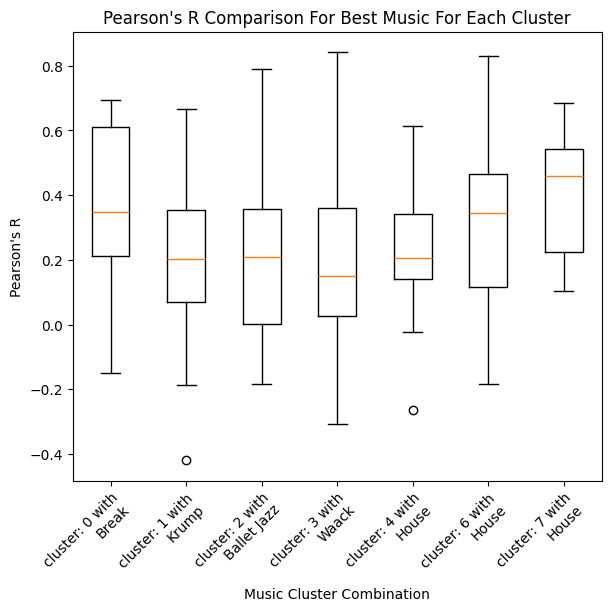

In [20]:
import numpy as np

# Do this for ordinal 1 first
win = 1
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "sort_key": np.quantile(rs, 0.1),
            "cluster": cluster,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
rs = []
labels = []
for cluster in clusters:
    cur_df = order_df.filter(
        pl.col("cluster") == cluster
    )
    cur_df = cur_df.sort(by=pl.col("sort_key"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison For Best Music For Each Cluster")

In [26]:
# get overall highest correlations

bests = pl.DataFrame()
for cluster in clusters:
    best_name_music_df = joined_df.group_by(
        pl.col("name"), pl.col("music"), pl.col("cluster")
    ).agg(
        r = pl.quantile("r", 0.9)
    ).filter(
        pl.col("cluster") == cluster,
        # pl.col("r") > -0.2,
        # pl.col("r") < 0.2,
    ).bottom_k(
        1, by=pl.col("r") 
    )
    best_c = best_name_music_df.select(
        pl.col("name"),
        pl.col("music"),
        pl.col("cluster"),
        pl.col("r"),
    )
    bests = bests.vstack(best_c)
print(bests)
bests.write_csv("worst_cluster_videos.csv")

shape: (8, 4)
┌──────────────────────────┬───────┬─────────┬───────────┐
│ name                     ┆ music ┆ cluster ┆ r         │
│ ---                      ┆ ---   ┆ ---     ┆ ---       │
│ str                      ┆ str   ┆ i64     ┆ f64       │
╞══════════════════════════╪═══════╪═════════╪═══════════╡
│ dance_data_15_corrected  ┆ mKR0  ┆ 0       ┆ -0.290824 │
│ dance_data_8_corrected   ┆ mBR0  ┆ 1       ┆ -0.097905 │
│ dance_data_209_corrected ┆ mJB0  ┆ 2       ┆ -0.206621 │
│ dance_data_177_corrected ┆ mLH0  ┆ 3       ┆ -0.209984 │
│ dance_data_180_corrected ┆ mJB0  ┆ 4       ┆ -0.171563 │
│ dance_data_77_corrected  ┆ mKR0  ┆ 5       ┆ -0.231114 │
│ dance_data_139_corrected ┆ mLH0  ┆ 6       ┆ -0.098795 │
│ dance_data_48_corrected  ┆ mBR0  ┆ 7       ┆ -0.233298 │
└──────────────────────────┴───────┴─────────┴───────────┘


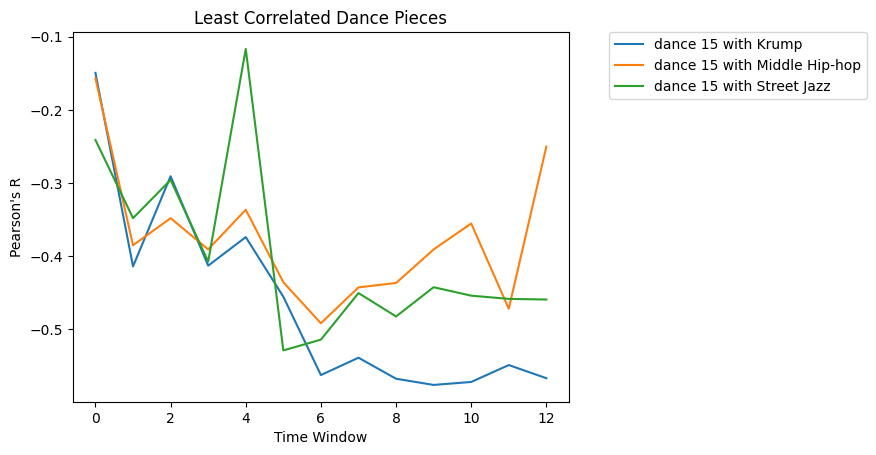

In [15]:

# get overall highest correlations
worst_name_music_df = joined_df.group_by(
    pl.col("name"), pl.col("music")
).agg(
    r = pl.quantile("r", 0.9)
).bottom_k(
    3, by="r"
)
worst = worst_name_music_df.select(
    pl.col("name"),
    pl.col("music"),
)
worst.write_csv("worst_videos.csv")

ax = plt.subplot()
for row in worst.iter_rows(named=True):
    name = row["name"]
    name_num = name.split("_")[2]
    music = row["music"]
    cur_df = joined_df.filter(
        pl.col("name") == name,
        pl.col("music") == music,
    )
    rs = []
    for win in wins:
        r = cur_df.filter(
            pl.col("win") == win
        )["r"].to_list()
        assert len(r) == 1, f"length of rs is not 1, is actually: {len(rs)}, music: {music}, name: {name}, win: {win}"
        rs.append(r)
    ax.plot(wins, rs, "", label=f"dance {name_num} with {music_dict[music]}")
ax.legend(bbox_to_anchor=(1.6, 1), loc="upper right", borderaxespad=0)
ax.set_xlabel("Time Window")
ax.set_ylabel("Pearson's R")
ax.set_title("Least Correlated Dance Pieces")
plt.show()

## Method 2: Using Euclidean Distance To Measure Similarity Of Motion

In [ ]:
# Analysis 3 - get r value of input to output
from scipy.stats import pearsonr
from tqdm import tqdm
import math

def euclid_dist(pt1, pt2):
    dist = 0
    for f1, f2 in zip(pt1, pt2):
        dist += (f1 - f2) ** 2
    return math.sqrt(dist)


input_df = pl.read_csv("features_complete.csv") 
output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
concat_df = output_df.select(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)
print(output_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


euc_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("num") == "0",
            pl.col("win_total") == "3",
            pl.col("music") == music,
        ).drop("name", "num", "win_total", "music")

        for win in range(0, 4):
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            euc_dist = euclid_dist(inputs[0, :], output[0, :])
            euc_dict = {"name": name, "music": music, "win": win, "euc": euc_dist}
            euc_df = euc_df.vstack(pl.from_dict(euc_dict))
    
euc_df.write_parquet("r_val_df.parquet")

In [ ]:
import matplotlib.pylab as plt

ax = plt.subplot()

euc_list = []
for win in range(0, 4):
    euc_dists = euc_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["euc"].to_numpy()
    euc_list.append(euc_dists)
ax.boxplot(euc_list)
ax.set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax.set_xlabel("Generated Timeframe (nth 3.7 seconds)")
ax.set_ylabel("Euclidean Distance")
ax.set_title("Euclidean Distance Comparison Inputs And Outputs")
plt.show()

In [ ]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("k-means-8n-final.csv").filter(
    pl.col("cluster") != 5
)
joined_df = euc_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(0, 4):
    euc_list = []
    for cluster in clusters:
        euc_dists = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["euc"].to_numpy()
        euc_list.append(euc_dists)
        
    axs[win].boxplot(euc_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Euclidean Distance")
    axs[win].set_title(f"Euclidean Distance Comparison For Timeframe Ordinal: {win + 1}")

# Concatenate Videos

In [ ]:

import subprocess
import argparse
import os
import polars as pl

video_dir = "../convert_video/"
concat_file = "best_dance_music_all_3.csv"
output_file = f"{concat_file.split(".")[0]}.mp4"
concat_video_df = pl.read_csv(concat_file)

videos = concat_video_df["name"].to_list().sort()
nums_list = []
for video in videos:
    video_name_split = video.split("_")
    video_index = video_name_split[2]
    nums_list.append(int(video_index))

nums_list.sort()
with open('filelist_with_text.txt', 'w') as file:
    for num in nums_list:
        file_name = f'dance_data_{num}_corrected.mp4'
        path = os.path.join(video_dir, file_name)
        file.write(f"file {path}\n")

subprocess.run([
    'ffmpeg', '-f', 'concat', '-safe', '0', '-i', 'filelist_with_text.txt', '-c', 'copy', output_file
], check=True)